CMPE 258 Assignment #3
1. Author: Tu Lan 011495497 tu.lan@sjsu.edu
2. Date: 03/02/2018
3. Tips: Before running the code, please change the Directories to yours, especially the directory of datasets

In [157]:
# basic libraries
import os               # a system library, not related to algorithm          
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

# state control
state = np.random.seed(1)

# To plot pretty figures
import seaborn as sns  # just a plot library. Not related to algorithms
%matplotlib inline
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

# Directories
PROJECT_ROOT_DIR = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/HW3'
DATA_DIR = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/data'

# Where to save the figures
IMAGE_FOLD = 'images'
IMAGE_DIR = os.path.join(PROJECT_ROOT_DIR, IMAGE_FOLD)

def save_fig(fig_id, tight_layout=True):
    if not os.path.exists(IMAGE_DIR):
        os.makedirs(IMAGE_DIR)
    path = os.path.join(IMAGE_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

1.Define functions


1.1 One-hot Encoding

In [2]:
def to_onehot(y, n_class):
    num = len(y)
    y_onehot = np.zeros((num, n_class), dtype=np.uint8)
    for i in range(num):
        y_onehot[i][y[i]] = 1
    return y_onehot

In [3]:
a = [4]
to_onehot(a, 10)

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=uint8)

1.2 Sigmiod

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
a = [[-1, -2], [0.1, 0.4]]
a = np.asarray(a)
print(sigmoid(a))

[[ 0.26894142  0.11920292]
 [ 0.52497919  0.59868766]]


In [71]:
def sigmoid_deri(x):
    return x * (1 - x)

In [72]:
a = [[-1, -2], [0.1, 0.4]]
a = np.asarray(a)
print(sigmoid_deri(a))

[[-2.   -6.  ]
 [ 0.09  0.24]]


In [6]:
def softmax(out):
    numerator = np.exp(out)
    denominator = np.sum(numerator, axis=1).reshape(-1, 1)
    scores = numerator / denominator
    return scores

In [7]:
a = [[-1, -2 , 0.9], [0.1, 0.4, 0.8]]
a = np.asarray(a)
print(softmax(a))

[[ 0.12416539  0.0456779   0.83015671]
 [ 0.22916797  0.3093444   0.46148762]]


1.3 - 1.6 I combine the functions in the class NeuralNet: 
1. parameter initialization in function '__init__'
2. forward propagation and backward propagation in function 'loss'
3. gradient descent in function 'train'

In [152]:
class NeuralNet(object):
    """
    - A 3-layer fully-connected neural network.
    - Architecture: input - Hidden Layer 1 - Sigmiod - Output Layer - Sigmoid - softmax
    """
    
    def __init__(self, input_size, h1_size, output_size):
        """
        - Input size: (N, D) N:number of samples,full batch D: dimension
        """
        # Parameter Initialization
        self.W1 = 0.01 * np.random.randn(input_size, h1_size)
        self.b1 = np.zeros(h1_size)
        self.W2 = 0.01 * np.random.randn(h1_size, output_size)
        self.b2 = np.zeros(output_size)
        self.grads = {}  # a dictionary

    def loss(self, X, y=None):
        
        N, D = X.shape
        y_onehot = to_onehot(y, 10)
        
        # Forward Propagation
        
        A1 = sigmoid(X.dot(self.W1) + self.b1)           # (N, h1_size)                      
        A2 = sigmoid(A1.dot(self.W2) + self.b2)          # (N, output_size)
        
        # If y is not given then jump out
        if y is None:
          return A2
        
        # Compute the loss: cross-entrophy loss 
        loss = 0.0     
        scores = softmax(A2)   # size: (N, output_size), each sample has 10 scores for each category
        for i in range(N):
            loss -= np.log(scores[i][y[i]])
        loss /= N              # mean loss 
        
        # Backward Propagation   
        delta_3 = A2 - y_onehot  # N, output_size
        delta_2 = delta_3.dot(self.W2.T) * sigmoid_deri(A1)         # (N, h1_size)
        
        dW2 = A1.T.dot(delta_3) / N
        dW1 = X.T.dot(delta_2) / N
        db2 = np.sum(delta_3, axis=0) / N
        db1 = np.sum(delta_2, axis=0) / N
        
        self.grads['W2'] = dW2
        self.grads['b2'] = db2
        self.grads['W1'] = dW1
        self.grads['b1'] = db1
        
        return loss, self.grads

    def train(self, X, y, X_val=None, y_val=None, learning_rate=1e-3, num_iters=100, verbose=False, printstep = 10):
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        
        for it in range(num_iters):     
            # Compute loss and gradients
            loss, grads = self.loss(X, y)
            
            # update parameters (gradient descent)
            self.W1 -= learning_rate * grads['W1']
            self.b1 -= learning_rate * grads['b1']
            self.W2 -= learning_rate * grads['W2']
            self.b2 -= learning_rate * grads['b2']

            # control verbose  
            if (verbose==True) and (X_val is not None) and ((it+1) % printstep == 0):
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc = (self.predict(X) == y).mean()
                print('iteration %d / %d: loss %f train_acc % f val_acc %f' % 
                      (it+1, num_iters, loss, train_acc, val_acc))  
                self.loss_history.append(loss)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                
            if (verbose==True) and (X_val is None) and ((it+1) % printstep == 0):
                train_acc = (self.predict(X) == y).mean()
                print('iteration %d / %d: loss %f train_acc % f' % 
                      (it+1, num_iters, loss, train_acc,))  
                self.loss_history.append(loss)
                self.train_acc_history.append(train_acc)
        return self

    def predict(self, X):
        X1 = sigmoid(X.dot(self.W1) + self.b1)
        X2 = X1.dot(self.W2) + self.b2
        scores = softmax(X2)
        y_pred = np.argmax(scores, axis=1)
        return y_pred



2.Read data and split data (The data has been normalized)

In [29]:
train_set = pd.read_csv(DATA_DIR + '/ex3_train.csv')
test_set = pd.read_csv(DATA_DIR + '/ex3_test.csv')
train_set.shape, test_set.shape

((3500, 401), (1500, 401))

In [30]:
train_set.info(), test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Columns: 401 entries, 0 to y
dtypes: float64(394), int64(7)
memory usage: 10.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 401 entries, 0 to y
dtypes: float64(389), int64(12)
memory usage: 4.6 MB


(None, None)

In [31]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,y
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5
1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5


In [32]:
X_train_all = train_set.iloc[:, :-1].values.astype('float64')
y_train_all = train_set['y'].values.astype('int64')
X_test = test_set.iloc[:, :-1].values.astype('float64')
y_test = test_set['y'].values.astype('int64')

X_train_all.shape, y_train_all.shape, X_test.shape, y_test.shape

((3500, 400), (3500,), (1500, 400), (1500,))

Visualize and analyze the data

Saving figure train set digit count


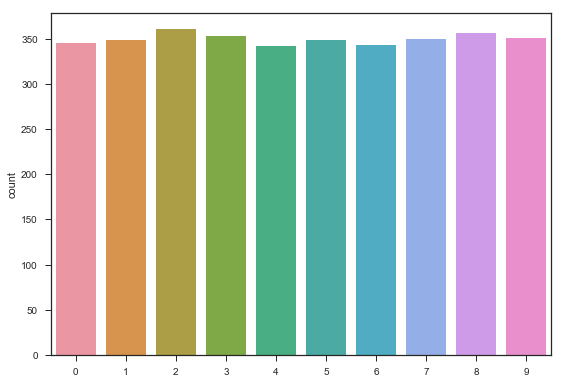

In [33]:
sns.countplot(y_train_all.ravel())
save_fig('train set digit count')

Every catogory has approximately 350 samples

In [ ]:

some_digit = X_train_all[10]
some_digit_image = some_digit.reshape(20, 20)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
y_train_all[10]

Split train and validation set

In [35]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train_all, y_train_all, 0.8, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2800, 400), (700, 400), (2800,), (700,))

we have 2800 samples for training, and 700 samples for validation

3.Initialize parameters: It will be done inside the neural network initialization

4.(20pts) Neural Network model with 1 hidden layer
Please build neural network model using input layer (400 neurons), 1 hidden layer (25 neurons), and output layer (10
neurons) using training data set.


In [91]:
net = NeuralNet(input_size=400, h1_size=25, output_size=10)
print('W1 size: ', net.W1.shape, '\nW2 size: ', net.W2.shape, 
      '\nb1 size: ', net.b1.shape, '\nb2 size: ', net.b2.shape)

W1 size:  (400, 25) 
W2 size:  (25, 10) 
b1 size:  (25,) 
b2 size:  (10,)


In [92]:
net.train(X_train, y_train, X_val, y_val, num_iters=1000, learning_rate=1, verbose=True)

iteration 0 / 1000: loss 2.314120 train_acc  0.097857 val_acc 0.107143


iteration 50 / 1000: loss 2.251024 train_acc  0.536786 val_acc 0.531429


iteration 100 / 1000: loss 1.992272 train_acc  0.793929 val_acc 0.778571


iteration 150 / 1000: loss 1.829667 train_acc  0.867500 val_acc 0.860000


iteration 200 / 1000: loss 1.744012 train_acc  0.896429 val_acc 0.878571


iteration 250 / 1000: loss 1.695646 train_acc  0.910000 val_acc 0.880000


iteration 300 / 1000: loss 1.663884 train_acc  0.920357 val_acc 0.887143


iteration 350 / 1000: loss 1.641275 train_acc  0.928929 val_acc 0.895714


iteration 400 / 1000: loss 1.624293 train_acc  0.935714 val_acc 0.898571


iteration 450 / 1000: loss 1.611003 train_acc  0.938929 val_acc 0.904286


iteration 500 / 1000: loss 1.600266 train_acc  0.945714 val_acc 0.910000


iteration 550 / 1000: loss 1.591367 train_acc  0.950357 val_acc 0.911429


iteration 600 / 1000: loss 1.583834 train_acc  0.952500 val_acc 0.914286


iteration 650 / 1000: loss 1.577341 train_acc  0.958214 val_acc 0.915714


iteration 700 / 1000: loss 1.571662 train_acc  0.960000 val_acc 0.914286


iteration 750 / 1000: loss 1.566632 train_acc  0.962143 val_acc 0.912857


iteration 800 / 1000: loss 1.562130 train_acc  0.963214 val_acc 0.912857


iteration 850 / 1000: loss 1.558060 train_acc  0.964286 val_acc 0.915714


iteration 900 / 1000: loss 1.554346 train_acc  0.966786 val_acc 0.917143


iteration 950 / 1000: loss 1.550932 train_acc  0.968929 val_acc 0.918571


5.(10pts) Predictions


In [104]:
y_pred_train = net.predict(X_train_all)
train_acc = (y_pred_train == y_train_all).mean()
y_pred_test = net.predict(X_test)
test_acc = (y_pred_test == y_test).mean()
print('train accuracy: %f\ntest accuracy: %f' % (train_acc, test_acc))

train accuracy: 0.960857
test accuracy: 0.916667


6.(20pts) Optimization


Tuning Learning Rate (choose different number of iterations to ensure it fully converges.)

In [134]:
# learning rate 1, num_iter = 5000
net1 = NeuralNet(input_size=400, h1_size=25, output_size=10)
net1.train(X_train, y_train, X_val, y_val, num_iters=5000, printstep=500, learning_rate=1, verbose=True)

iteration 500 / 5000: loss 1.596790 train_acc  0.948214 val_acc 0.901429


iteration 1000 / 5000: loss 1.543554 train_acc  0.973571 val_acc 0.910000


iteration 1500 / 5000: loss 1.519354 train_acc  0.986071 val_acc 0.912857


iteration 2000 / 5000: loss 1.504614 train_acc  0.992143 val_acc 0.915714


iteration 2500 / 5000: loss 1.495056 train_acc  0.996429 val_acc 0.917143


iteration 3000 / 5000: loss 1.488530 train_acc  0.997857 val_acc 0.918571


iteration 3500 / 5000: loss 1.483895 train_acc  0.997857 val_acc 0.921429


iteration 4000 / 5000: loss 1.480478 train_acc  0.998571 val_acc 0.922857


iteration 4500 / 5000: loss 1.477868 train_acc  0.998571 val_acc 0.922857


iteration 5000 / 5000: loss 1.475817 train_acc  0.998929 val_acc 0.921429


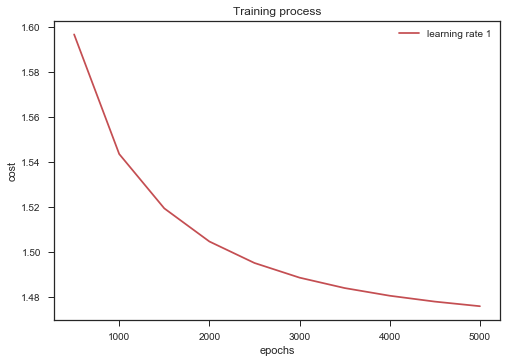

In [136]:
plt.plot(np.arange(1, len(net1.loss_history) + 1) * 500, net1.loss_history, 'r-', 
         label='learning rate 1')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.title('Training process')
plt.legend(loc='upper right')

In [138]:
# learning rate 2, num_iter = 4000
net2 = NeuralNet(input_size=400, h1_size=25, output_size=10)
net2.train(X_train, y_train, X_val, y_val, num_iters=4000, printstep=400, learning_rate=2, verbose=True)

iteration 400 / 4000: loss 1.582195 train_acc  0.952143 val_acc 0.897143


iteration 800 / 4000: loss 1.532027 train_acc  0.976429 val_acc 0.910000


iteration 1200 / 4000: loss 1.509536 train_acc  0.990000 val_acc 0.912857


iteration 1600 / 4000: loss 1.495955 train_acc  0.995357 val_acc 0.910000


iteration 2000 / 4000: loss 1.487274 train_acc  0.998571 val_acc 0.912857


iteration 2400 / 4000: loss 1.481566 train_acc  0.998929 val_acc 0.917143


iteration 2800 / 4000: loss 1.477760 train_acc  0.998929 val_acc 0.921429


iteration 3200 / 4000: loss 1.475063 train_acc  0.999286 val_acc 0.922857


iteration 3600 / 4000: loss 1.473070 train_acc  0.999286 val_acc 0.920000


iteration 4000 / 4000: loss 1.471544 train_acc  0.999286 val_acc 0.918571


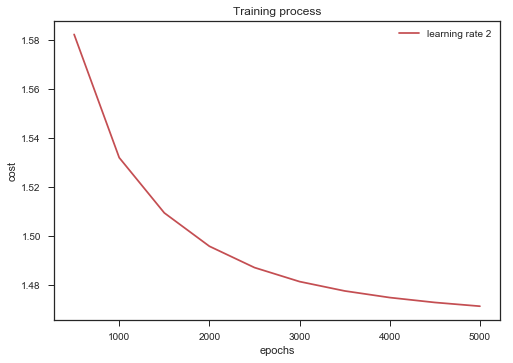

In [140]:
plt.plot(np.arange(1, len(net2.loss_history) + 1) * 500, net2.loss_history, 'r-', 
         label='learning rate 2')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.title('Training process')
plt.legend(loc='upper right')

In [133]:
# learning rate 0.3, num_iter = 8000
net3 = NeuralNet(input_size=400, h1_size=25, output_size=10)
net3.train(X_train, y_train, X_val, y_val, num_iters=8000, printstep=800, learning_rate=0.3, verbose=True)

iteration 800 / 8000: loss 1.694742 train_acc  0.912143 val_acc 0.878571


iteration 1600 / 8000: loss 1.600240 train_acc  0.943571 val_acc 0.902857


iteration 2400 / 8000: loss 1.567811 train_acc  0.960714 val_acc 0.912857


iteration 3200 / 8000: loss 1.548999 train_acc  0.970357 val_acc 0.912857


iteration 4000 / 8000: loss 1.535874 train_acc  0.976429 val_acc 0.917143


iteration 4800 / 8000: loss 1.525798 train_acc  0.981071 val_acc 0.920000


iteration 5600 / 8000: loss 1.517630 train_acc  0.987857 val_acc 0.921429


iteration 6400 / 8000: loss 1.510850 train_acc  0.990714 val_acc 0.921429


iteration 7200 / 8000: loss 1.505195 train_acc  0.992857 val_acc 0.921429


iteration 8000 / 8000: loss 1.500446 train_acc  0.993929 val_acc 0.922857


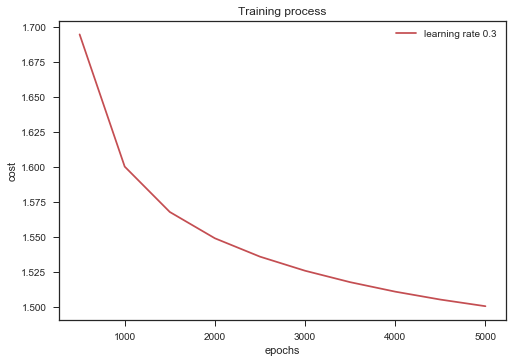

In [158]:
plt.plot(np.arange(1, len(net3.loss_history) + 1) * 500, net3.loss_history, 'r-', 
         label='learning rate 0.3')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.title('Training process')
plt.legend(loc='upper right')

In [142]:
# learning rate 0.1, num_iter = 12000
net4 = NeuralNet(input_size=400, h1_size=25, output_size=10)
net4.train(X_train, y_train, X_val, y_val, num_iters=12000, printstep=1200, learning_rate=0.1, verbose=True)

iteration 1200 / 12000: loss 1.896655 train_acc  0.833571 val_acc 0.824286


iteration 2400 / 12000: loss 1.700186 train_acc  0.912857 val_acc 0.882857


iteration 3600 / 12000: loss 1.632485 train_acc  0.932500 val_acc 0.891429


iteration 4800 / 12000: loss 1.600670 train_acc  0.943571 val_acc 0.902857


iteration 6000 / 12000: loss 1.581438 train_acc  0.952143 val_acc 0.911429


iteration 7200 / 12000: loss 1.567934 train_acc  0.960714 val_acc 0.910000


iteration 8400 / 12000: loss 1.557564 train_acc  0.965357 val_acc 0.911429


iteration 9600 / 12000: loss 1.549119 train_acc  0.970357 val_acc 0.914286


iteration 10800 / 12000: loss 1.541978 train_acc  0.972857 val_acc 0.914286


iteration 12000 / 12000: loss 1.535819 train_acc  0.977500 val_acc 0.912857


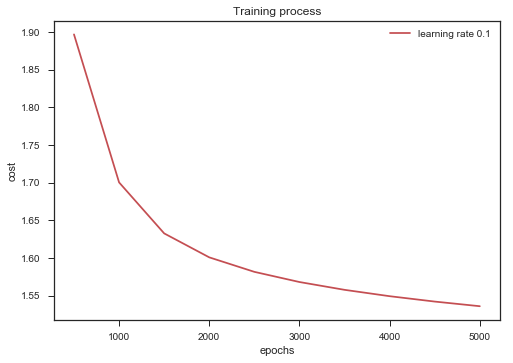

In [159]:
plt.plot(np.arange(1, len(net4.loss_history) + 1) * 500, net4.loss_history, 'r-', 
         label='learning rate 0.1')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.title('Training process')
plt.legend(loc='upper right')

summarize in 1 figure

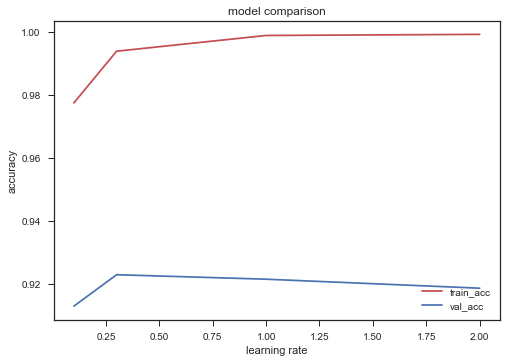

In [145]:
learning_rate = [0.1, 0.3, 1, 2]
train_acc = [net4.train_acc_history[-1], net3.train_acc_history[-1], 
             net1.train_acc_history[-1], net2.train_acc_history[-1]]
val_acc = [net4.val_acc_history[-1], net3.val_acc_history[-1], 
             net1.val_acc_history[-1], net2.val_acc_history[-1]]
plt.plot(learning_rate, train_acc, 'r-', label='train_acc')
plt.plot(learning_rate, val_acc, 'b-', label='val_acc')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.title('model comparison')
plt.legend(loc='lower right')

I will choose learning rate 0.3, and traing it deeper.


In [154]:
# learning rate 0.3, num_iter = 15000
# Using all the training set to train the network, so there's no validation process here
net_final = NeuralNet(input_size=400, h1_size=25, output_size=10)
net_final.train(X_train_all, y_train_all, num_iters=15000, printstep=1500, learning_rate=0.3, verbose=True)

iteration 1500 / 15000: loss 1.611025 train_acc  0.935143


iteration 3000 / 15000: loss 1.558990 train_acc  0.959714


iteration 4500 / 15000: loss 1.536172 train_acc  0.974000


iteration 6000 / 15000: loss 1.521429 train_acc  0.981429


iteration 7500 / 15000: loss 1.510873 train_acc  0.987143


iteration 9000 / 15000: loss 1.502974 train_acc  0.990571


iteration 10500 / 15000: loss 1.496870 train_acc  0.995143


iteration 12000 / 15000: loss 1.491991 train_acc  0.996857


iteration 13500 / 15000: loss 1.487998 train_acc  0.998000


iteration 15000 / 15000: loss 1.484722 train_acc  0.998286


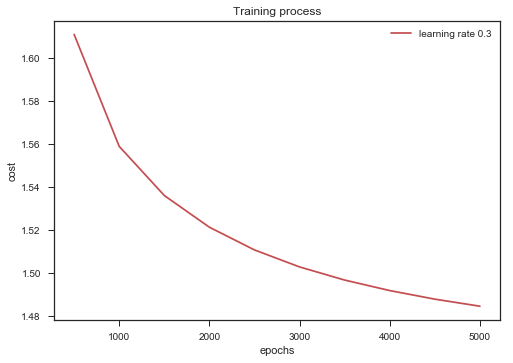

In [160]:
plt.plot(np.arange(1, len(net_final.loss_history) + 1) * 500, net_final.loss_history, 'r-', 
         label='learning rate 0.3')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.title('Training process')
plt.legend(loc='upper right')

In [156]:
test_pred = net_final.predict(X_test)
test_acc = (test_pred == y_test).mean()
print('Final Test Accuracy: ', test_acc)

Final Test Accuracy:  0.928


1. The final test accuracy is 0.928. It seems ok cause we didn't use the full data set which is about 70000 images. We only use 3500 training set here. I've built a CNN model trained with the full data set before. It achieves 99.7% test accuracy.
2. Besides, This assignment don't ask to use regularization. If L2 applied, the result might be better. 